# SARIMA notebook
<br>
This notebook examines SARIMA modeling using statsmodels. One limitation with sktime is the inability to extract the fitted values or residuals from the trained model. In order to perform our residual diagnostics, we will have to fit with statsmodels

# Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.datasets import load_airline
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

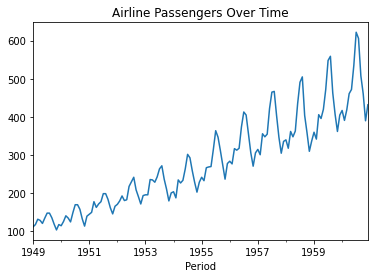

In [2]:
y = load_airline()
y.plot(title='Airline Passengers Over Time')
plt.show()

In [3]:
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

## Take a log transformation

In [5]:
bctransformer = boxcox.BoxCoxTransformer()
y_transf = bctransformer.fit_transform(y)
y_transf

Period
1949-01     6.827490
1949-02     6.932822
1949-03     7.161892
1949-04     7.114611
1949-05     6.983787
             ...    
1960-08    10.684049
1960-09    10.234573
1960-10     9.992159
1960-11     9.582623
1960-12     9.831860
Freq: M, Length: 144, dtype: float64

# Split y into Train and Test Groups

In [6]:
from sktime.forecasting.all import temporal_train_test_split

In [7]:
y_train, y_test = temporal_train_test_split(y_transf)

In [8]:
y_train.index.min(), y_train.index.max()

(Period('1949-01', 'M'), Period('1957-12', 'M'))

In [9]:
y_test.index.min(), y_test.index.max()

(Period('1958-01', 'M'), Period('1960-12', 'M'))

## Examine stationarity

In [10]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [11]:
#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [12]:
adf_test(y_train)

Results of Dickey-Fuller Test:
Test Statistic                 -0.657980
p-value                         0.857336
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [13]:
alpha = 0.05
ad_fuller_results = adfuller(y_train)
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

stationarity from ad_fuller test: False


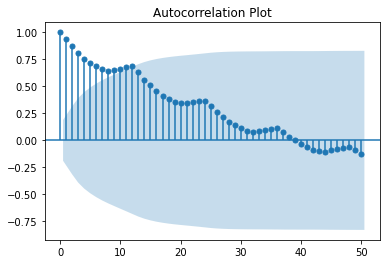

In [14]:
p = plot_acf(y_train,lags=50, title='Autocorrelation Plot')

# Difference the data and examine

In [15]:
y_train_seasdiff = y.diff(12).dropna()
# y_train_seasdiff.head(20)

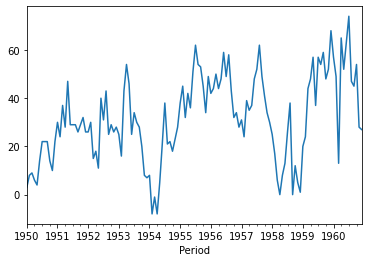

In [16]:
y_train_seasdiff.plot()
plt.show()

# Conclusions
 - Do we think this is stationary?
 - How can we check?

In [31]:
alpha=0.05

In [32]:
ad_fuller_results = adfuller(y_train_seasdiff)
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

stationarity from ad_fuller test: True


In [33]:
kpss_test_results = kpss(y_train_seasdiff)
kpss_pval = kpss_test_results[1]
kpss_test_bool = kpss_pval >= alpha

print(f'stationarity from KPSS test: {kpss_test_bool}')

stationarity from KPSS test: True


c:\users\meenu\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


# Examine Autocorrelation plots

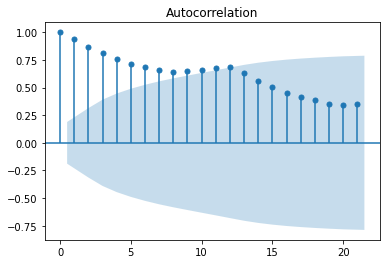

In [34]:
plot_acf(y_train)
plt.show()

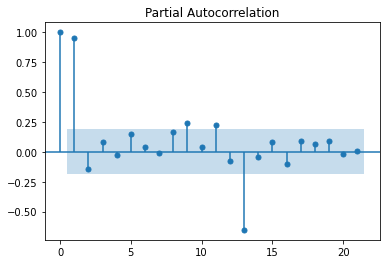

In [35]:
plot_pacf(y_train)
plt.show()

# Conlusions

 - What does the ACF tell us about the airline data?
 - What does the PACF tell us about the airline data?

# SARIMA

S in ARIMA stands for the seasonal component

Add a difference with the middle parameter

### Model 1

In [17]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(1,0,0), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                  82.658
Date:                            Tue, 27 Apr 2021   AIC                           -161.317
Time:                                    08:50:32   BIC                           -156.188
Sample:                                01-31-1949   HQIC                          -159.244
                                     - 12-31-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9431      0.029     32.856      0.000       0.887       0.999
sigma2         0.0102      0.001   

c:\users\meenu\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Aicc inputs are
 - Log likelihood
 - Number of observations
 - Number of parameters

In [37]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (1, 0, 0)(0, 1, 0, 12): -161.1879053737495


<AxesSubplot:xlabel='Period'>

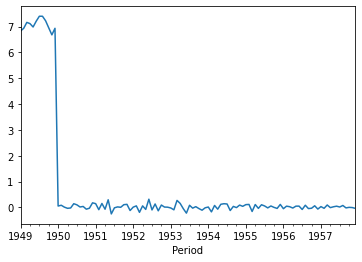

In [18]:
resid = sarima_fit.resid
resid.plot()

In [20]:
resid

Period
1949-01    6.827490
1949-02    6.932822
1949-03    7.161890
1949-04    7.114609
1949-05    6.983785
             ...   
1957-08    0.074899
1957-09   -0.018831
1957-10    0.002486
1957-11   -0.006037
1957-12   -0.037957
Freq: M, Length: 108, dtype: float64

### Why do we have this drop off?

In [39]:
resid=resid[12:]
resid

Period
1950-01    0.053246
1950-02    0.083340
1950-03    0.010585
1950-04   -0.035123
1950-05   -0.022022
             ...   
1957-08    0.074899
1957-09   -0.018831
1957-10    0.002486
1957-11   -0.006037
1957-12   -0.037957
Freq: M, Length: 96, dtype: float64

<AxesSubplot:xlabel='Period'>

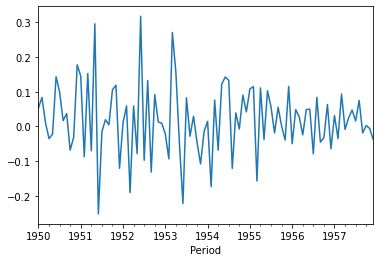

In [40]:
resid.plot()

<AxesSubplot:>

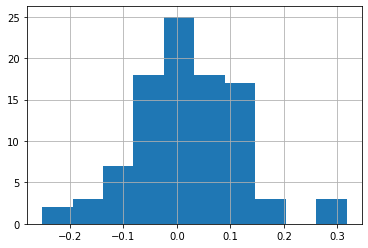

In [41]:
resid.hist()

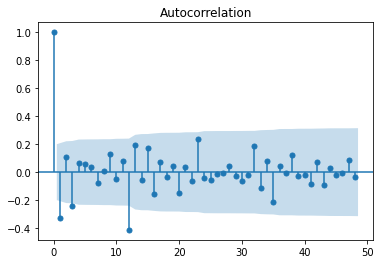

In [42]:
plot_acf(resid, lags=48)
plt.show()

In [43]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,21.469282,0.018049,20.432578,0.025417


# Try other models and compare AIC/BIC

### Model 2

In [44]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(1,0,1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                  87.879
Date:                             Fri, 23 Apr 2021   AIC                           -169.757
Time:                                     12:41:09   BIC                           -162.064
Sample:                                 01-31-1949   HQIC                          -166.648
                                      - 12-31-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9770      0.021     45.739      0.000       0.935       1.019
ma.L1         -0.3677      

In [45]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))


AICc for order (1, 0, 1)(0, 1, 0, 12): -169.49635916929284


In [46]:
resid = sarima_fit.resid
resid=resid[12:]

<AxesSubplot:xlabel='Period'>

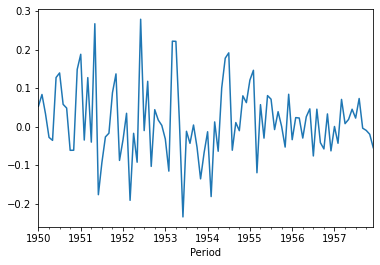

In [47]:
resid.plot()

<AxesSubplot:>

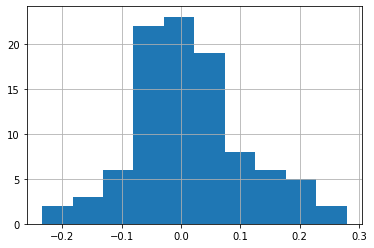

In [48]:
resid.hist()

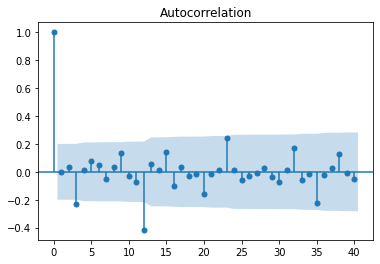

In [49]:
plot_acf(resid, lags=40)
plt.show()

In [50]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.624039,0.568116,8.024609,0.626433


### Model 3

In [51]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(1,0,1), seasonal_order=(1, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                  97.669
Date:                             Fri, 23 Apr 2021   AIC                           -187.338
Time:                                     12:41:10   BIC                           -177.080
Sample:                                 01-31-1949   HQIC                          -183.192
                                      - 12-31-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9910      0.012     84.450      0.000       0.968       1.014
ma.L1         -0.4055      

In [52]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))


AICc for order (1, 0, 1)(1, 1, 0, 12): -186.89814960246022


In [53]:
resid = sarima_fit.resid
resid=resid[12:]

<AxesSubplot:xlabel='Period'>

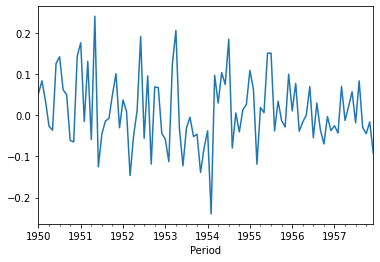

In [54]:
resid.plot()

<AxesSubplot:>

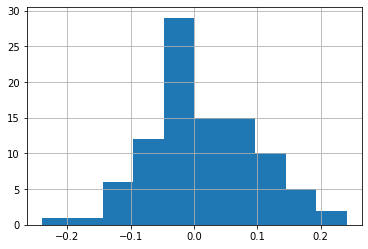

In [55]:
resid.hist()

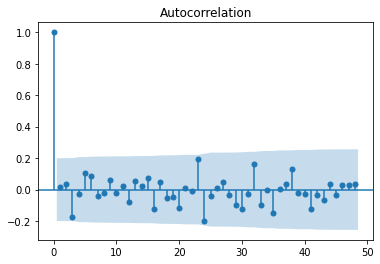

In [56]:
plot_acf(resid, lags=48)
plt.show()

In [57]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,6.025494,0.813117,5.633311,0.845073


In [58]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))


AICc for order (1, 0, 1)(1, 1, 0, 12): -186.89814960246022


# Fit with the best (happens to be the most recent) model

Best practice is to use specific model names

In [72]:
y_pred=sarima_fit.forecast()

In [73]:
y_pred

1958-01    9.320324
Freq: M, dtype: float64

## Plot the results where blue is actual and the red is your prediction

<AxesSubplot:xlabel='Period'>

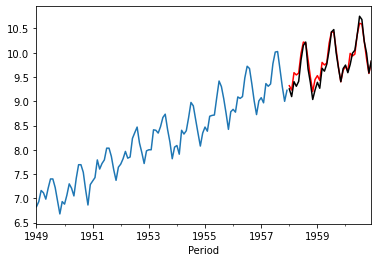

In [43]:
# plot
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## Evaluate yhat

In [61]:
from sktime.performance_metrics.forecasting import smape_loss

In [62]:
smape_loss(y_test, y_pred )

0.009811948716704938

### If we build other models using different modeling methods, such as ARIMA or prophet, we would compare those **forecast** results by using error metrics like sMAPE